## Bigg Boss Hindi/Kannada/Tamil/Telugu/Malayalam/Marathi/Bangla Data sets and Data Analysis

## https://satya-python.blogspot.com/

### Importing Required Python Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Import dataset

In [2]:
bigg_boss = pd.read_csv('/kaggle/input/Bigg_Boss_India.csv', encoding = "ISO-8859-1")
nRow, nCol = bigg_boss.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 549 rows and 21 columns


## Exploratory Data Analysis (EDA)

In [3]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,3.0,0.0,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,6.0,0.0,0.0,0.0


In [4]:
bigg_boss.tail(10).T

,539,540,541,542,543,544,545,546,547,548
Language,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam
Season Number,1,1,1,1,1,1,1,1,1,1
Name,Hima Shankar,Manoj K. Verma,Pearle Maaney,Ranjini Haridas,Sabumon Abdusamad,Shweta Menon,Sreelakshmi Sreekumar,Srinish Aravind,Anjali Ameer,Shiyas Kareem
Profession,Actress,Businessman,Actress,TV Anchor,TV Anchor,Actress,Actress,Soap Actor,Actress,Actor
Gender,Female,Male,Female,Female,Male,Female,Female,Male,Female,Male
Entry Date,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,11,NaN,14,9,NaN,5,4,14,NaN,14
Wild Card,No,No,No,No,No,No,No,No,Yes,Yes
Season Length,98,98,98,98,98,98,98,98,98,98


In [5]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
495,Marathi,2,Surekha Punekar,Choreographer,Female,26-May-19,NaN,6.0,No,98,17,26-May-19,01-Sep-19,Mahesh Manjrekar,0,Colors Marathi,NaN,2.0,0.0,0.0,0.0
253,Kannada,2,Anita Bhat,Actress,Female,29-Jun-14,NaN,1.0,No,98,15,29-Jun-14,5-Oct-14,Sudeep,0,Suvarna,NaN,1.0,0.0,0.0,0.0
201,Hindi,12,Nirmal Singh,Commoner - Police,Male,16-Sep-18,NaN,2.0,No,105,20,16-Sep-18,30-Dec-18,Salman Khan,0,Colors,4.99,1.0,0.0,0.0,0.0
291,Kannada,4,Mohan Shankar,Actor,Male,09-Oct-16,NaN,NaN,No,112,18,09-Oct-16,29-Jan-17,Sudeep,0,Colors Kannada,NaN,NaN,NaN,NaN,0.0
317,Kannada,5,Suma Rajkumar,Commoner - Housewife,Female,15-Oct-17,NaN,1.0,No,106,20,15-Oct-17,28-Jan-18,Sudeep,0,Colors Kannada,NaN,1.0,0.0,0.0,0.0
438,Tamil,2,Mumtaz,Actress,Female,17-Jun-18,NaN,13.0,No,105,17,17-Jun-18,30-Sep-18,Kamal Haasan,0,Start Vijay,8.20,8.0,0.0,0.0,0.0
99,Hindi,7,Apurva Agnihotri,Actor,Male,15-Sep-13,NaN,7.0,No,105,20,15-Sep-13,28-Dec-13,Salman Khan,0,Colors,4.40,1.0,0.0,1.0,0.0
203,Hindi,12,Roshmi Banik,Commoner - Business,Female,16-Sep-18,NaN,2.0,No,105,20,16-Sep-18,30-Dec-18,Salman Khan,0,Colors,4.99,3.0,0.0,1.0,0.0
10,Hindi,1,Ravi Kishan,Actor,Male,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,5.0,0.0,0.0,0.0
12,Hindi,1,Salil Ankola,Sports Person,Male,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,0.0,0.0,0.0,0.0


In [6]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 21 columns):
Language                              549 non-null object
Season Number                         549 non-null int64
Name                                  549 non-null object
Profession                            549 non-null object
Gender                                549 non-null object
Entry Date                            471 non-null object
Elimination Date                      96 non-null object
Elimination Week Number               448 non-null float64
Wild Card                             549 non-null object
Season Length                         549 non-null int64
Number of Housemates                  549 non-null int64
Season Start Date                     549 non-null object
Season End Date                       549 non-null object
Host Name                             549 non-null object
Prize Money (INR)                     528 non-null object
Broadcasted By              

In [7]:
bigg_boss.describe()

,Season Number,Elimination Week Number,Season Length,Number of Housemates,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
count,549.000000,448.000000,549.000000,549.000000,352.000000,501.000000,501.000000,486.000000,527.000000
mean,4.732240,8.850446,101.510018,17.921676,5.370909,3.844311,0.087824,0.537037,0.055028
std,3.625649,4.532009,11.185659,1.932073,2.314201,2.629014,0.297105,0.744510,0.228252
min,1.000000,1.000000,70.000000,15.000000,2.720000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,98.000000,17.000000,3.540000,2.000000,0.000000,0.000000,0.000000
50%,3.000000,9.000000,100.000000,18.000000,4.700000,3.000000,0.000000,0.000000,0.000000
75%,7.000000,13.000000,105.000000,20.000000,7.800000,6.000000,0.000000,1.000000,0.000000
max,13.000000,16.000000,140.000000,22.000000,10.330000,12.000000,2.000000,5.000000,1.000000


In [8]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col,"-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 13
Number of unique values in Name - 547
Number of unique values in Profession - 74
Number of unique values in Gender - 3
Number of unique values in Entry Date - 36
Number of unique values in Elimination Date - 53
Number of unique values in Elimination Week Number - 16
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 12
Number of unique values in Number of Housemates - 7
Number of unique values in Season Start Date - 31
Number of unique values in Season End Date - 29
Number of unique values in Host Name - 15
Number of unique values in Prize Money (INR) - 4
Number of unique values in Broadcasted By - 11
Number of unique values in Average TRP - 19
Number of unique values in Number of Evictions Faced - 13
Number of unique values in Number of re-entries - 3
Number of unique values in Number of times elected as Captain - 6
Number of unique values in Winner - 2


In [9]:
# Number of seasons in all Indian languages
print(bigg_boss.groupby('Language')['Season Number'].nunique().sum())

# 31 seasons happened (including current seasons)

31


## https://www.kaggle.com/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

## Bigg Boss Hindi has many seasons compared to other Indian languages. So, number of housemates are more in Hindi.

In [10]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi      13
Kannada     7
Tamil       3
Telugu      3
Bengali     2
Marathi     2
Malayam     1
Name: Season Number, dtype: int64


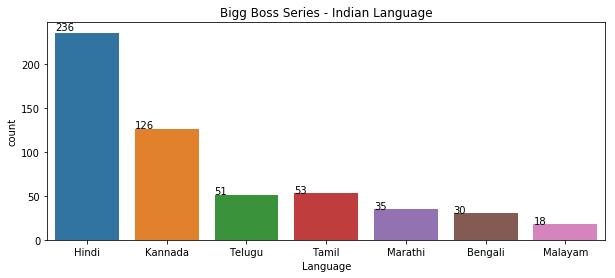

In [11]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10,4))
ax = sns.countplot(x='Language', data=bigg_boss)
ax.set_title('Bigg Boss Series - Indian Language')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates (84%) entered in first day/week

No     463
Yes     86
Name: Wild Card, dtype: int64 

No     84.0
Yes    16.0
Name: Wild Card, dtype: float64


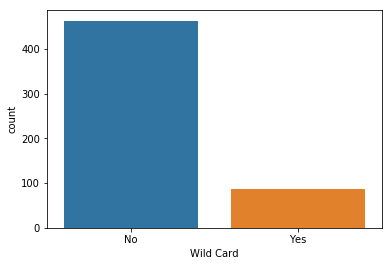

In [12]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100))
sns.countplot(x='Wild Card', data=bigg_boss)

In [14]:
# Common people has many professions, so clubbing them into one category
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession']='Commoner'

## Number of film actress entered into the Bigg Boss houses, are more when compared to other professions 

Actress                  129
Actor                     92
Commoner                  39
Soap Actress              38
Model                     38
Singer                    29
Soap Actor                27
TV Anchor                 19
Reality Show Alumni       16
Comedian                  13
Radio Jockey              10
News Presenter            10
Sports Person              7
Choreographer              7
International Star         6
Film Director              5
LGBT                       5
Pageant Winner             4
Social Media Star          4
Controversial Fame         4
Swamiji                    4
Politician                 4
Producer                   4
Wrestler                   3
Businessman                2
Dancer                     2
Video Jockey               2
Stage Actress              2
Activist                   2
Journalist                 2
Fashion Designer           2
Lyricist                   1
Air Hostess                1
Celebrity Hairstylist      1
Political Anal

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 49 Text xticklabel objects>)

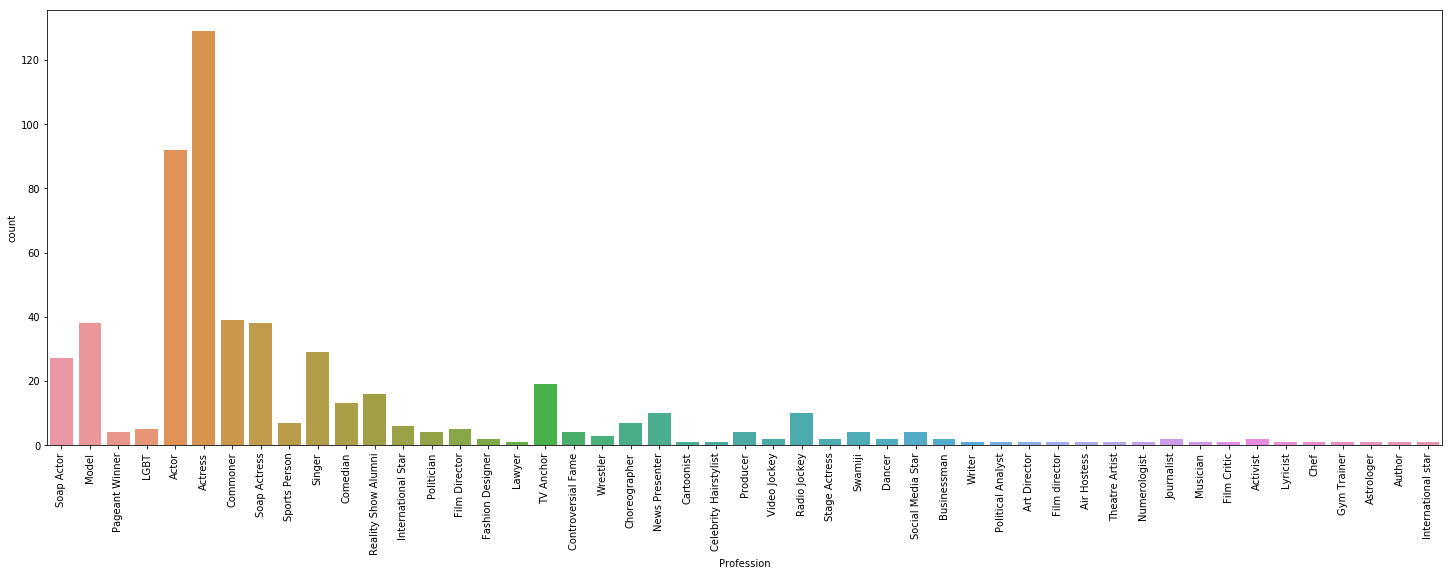

In [15]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(25,8))
sns.countplot(x='Profession', data=bigg_boss)
plt.xticks(rotation=90)

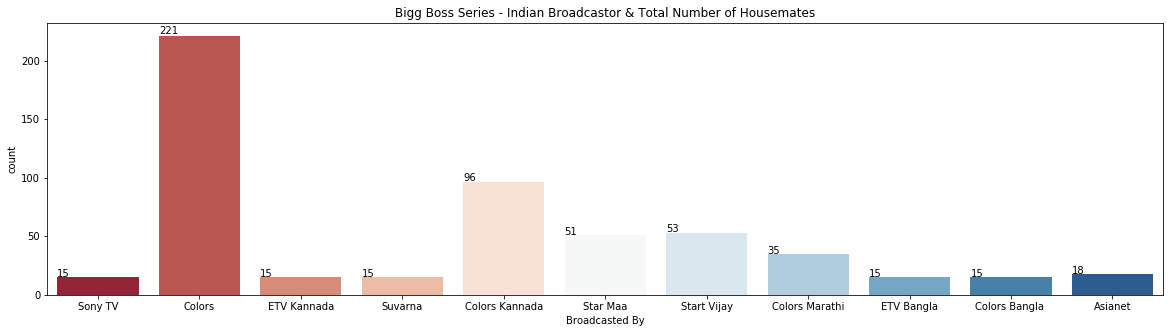

In [16]:
# Broadcastor
fig = plt.figure(figsize=(20,5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu')
ax.set_title('Bigg Boss Series - Indian Broadcastor & Total Number of Housemates')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next in the list

In [17]:
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan                8
Sudeep                     7
Kamal Haasan               3
Mahesh Manjrekar           2
Amitabh Bachchan           1
Arshad Warsi               1
Jeet                       1
Jr. NTR                    1
Mithun Chakraborthy        1
Mohanlal                   1
Nagarjuna                  1
Nani                       1
Salman Khan/Farah Khan     1
Salman Khan/Sanjay Dutt    1
Shilpa Shetty              1
Name: Season Number, dtype: int64

## In all Bigg Boss languages, and in all seasons, Female contestants are more

In [18]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts())

Female         287
Male           257
Transgender      5
Name: Gender, dtype: int64


### 5 Transgenders participated in all Indian languages

In [19]:
# Maximum TRP of Bigg Boss Hindi/India seasons
print("Maximum TRP",bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 10.33 

Language  Season Number
 Malayam              1


In [20]:
# Longest season of Bigg Boss Hindi/India seasons
print("Longest season",bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 140 days 

Language  Season Number
   Hindi             13


## https://satya-data.blogspot.com/2018/01/bigg-boss-data-set-bigg-boss.html

In [21]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
8,Hindi,1,Rahul Roy,Actor,Male,03-Nov-06,NaN,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,"1,00,00,000",Sony TV,2.72,4.0,0.0,0.0,1.0
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,17-Aug-08,NaN,NaN,No,98,15,17-Aug-08,22-Nov-08,Shilpa Shetty,"1,00,00,000",Colors,2.89,4.0,0.0,0.0,1.0
42,Hindi,3,Vindu Dara Singh,Actor,Male,04-Oct-09,NaN,NaN,No,84,15,04-Oct-09,26-Dec-09,Amitabh Bachchan,"1,00,00,000",Colors,2.83,7.0,0.0,0.0,1.0
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,03-Oct-10,NaN,NaN,No,96,16,03-Oct-10,08-Jan-11,Salman Khan,"1,00,00,000",Colors,4.95,4.0,0.0,2.0,1.0
62,Hindi,5,Juhi Parmar,Soap Actress,Female,02-Oct-11,NaN,NaN,No,98,18,02-Oct-11,07-Jan-12,Salman Khan/Sanjay Dutt,"1,00,00,000",Colors,4.19,4.0,0.0,1.0,1.0
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,07-Oct-12,NaN,NaN,No,97,19,07-Oct-12,12-Jan-13,Salman Khan,"50,00,000",Colors,3.81,6.0,0.0,1.0,1.0
102,Hindi,7,Gauhar Khan,Actress,Female,15-Sep-13,NaN,NaN,No,105,20,15-Sep-13,28-Dec-13,Salman Khan,"50,00,000",Colors,4.40,7.0,0.0,2.0,1.0
121,Hindi,8,Gautam Gulati,Actor,Male,21-Sep-14,NaN,NaN,No,105,19,21-Sep-14,03-Jan-15,Salman Khan/Farah Khan,"50,00,000",Colors,3.77,10.0,0.0,1.0,1.0
144,Hindi,9,Prince Narula,Reality Show Alumni,Male,11-Oct-15,NaN,NaN,No,105,20,11-Oct-15,23-Jan-16,Salman Khan,"50,00,000",Colors,2.90,6.0,0.0,4.0,1.0
165,Hindi,10,Manveer Gurjar,Commoner,Male,16-Oct-16,NaN,NaN,No,105,18,16-Oct-16,28-Jan-17,Salman Khan,"50,00,000",Colors,3.54,7.0,0.0,4.0,1.0


In [22]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Profession'].value_counts()

Actor                  6
Actress                5
Soap Actress           4
Singer                 4
Reality Show Alumni    3
TV Anchor              2
Commoner               2
Film Director          1
Model                  1
Soap Actor             1
Name: Profession, dtype: int64

In [23]:
# Gender of Season title Winners
bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts()

Male      20
Female     9
Name: Gender, dtype: int64

In [25]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1,'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

4.0     7
5.0     3
6.0     5
7.0     5
9.0     3
10.0    1
11.0    2
Name: Number of Evictions Faced, dtype: int64

## No wild card entry housemate won the Bigg Boss competition.

In [26]:
# Entry type of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Wild Card'].value_counts()

No    29
Name: Wild Card, dtype: int64

In [27]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1,'Number of re-entries'].value_counts()

0.0    26
Name: Number of re-entries, dtype: int64

In [ ]:
# Bigg Boss winners Number of times elected as Captain
bigg_boss.loc[bigg_boss.Winner==1,'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain   - Number of winners

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(bigg_boss)

## Machine Learning Models to predict Indian Bigg Boss season Winners

## Telugu Bigg Boss
## https://www.kaggle.com/thirumani/predicting-bigg-boss-telugu-season-3-winner

## Kannada Bigg Boss
## https://www.kaggle.com/thirumani/predicting-bigg-boss-kannada-season-7-winner

## Hindi Bigg Boss
## https://www.kaggle.com/thirumani/predicting-bigg-boss-hindi-season-13-winner